In [0]:
!wget https://gitlab.com/federicozzo/electiveai/raw/master/Desktop/uni/elective_AI/electiveai/bdd100K_img.zip?inline=false

--2019-11-17 09:56:55--  https://gitlab.com/federicozzo/electiveai/raw/master/Desktop/uni/elective_AI/electiveai/bdd100K_img.zip?inline=false
Resolving gitlab.com (gitlab.com)... 35.231.145.151
Connecting to gitlab.com (gitlab.com)|35.231.145.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6868891483 (6.4G) [application/zip]
Saving to: ‘bdd100K_img.zip?inline=false’

bdd100K_img.zip?inl 100%[===================>]   6.40G  32.2MB/s    in 3m 10s  

2019-11-17 10:00:06 (34.5 MB/s) - ‘bdd100K_img.zip?inline=false’ saved [6868891483/6868891483]



In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np
import IPython.display as display
import cv2
import json
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
drive.flush_and_unmount()

In [3]:
with open("/content/bdd100k/labels/bdd100k_labels_images_train.json", "r") as f:
    train_images_label = json.load(f)

FileNotFoundError: ignored

In [0]:
with open("/content/bdd100k/labels/bdd100k_labels_images_val.json", "r") as f:
    test_images_label = json.load(f)

In [0]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [0]:
def load_image(addr):
    # read an image and resize to (128, 128)
    # cv2 load images as BGR, convert it to RGB
    img = cv2.imread(addr)
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    return img

In [0]:
def find_img_in_labels(name):
    name = name.split("/")[-1]
    for image in train_images_label:
        if image['name'] == name:
            return image
    return None

In [0]:
def find_img_in_test_labels(name):
    name = name.split("/")[-1]
    for image in test_images_label:
        if image['name'] == name:
            return image
    return None

In [0]:
for image in train_images_label:
    if image['attributes']['timeofday'] not in ['daytime', 'night', 'dawn/dusk', 'undefined']:
        print(image['name'], image['attributes']['timeofday'])
        

In [0]:
def writeTfRecord(input_path, output_path, setname):
    # open the TFRecords file
    writer = tf.python_io.TFRecordWriter(output_path)
    images_filenames = [input_path+fn for fn in os.listdir(path=input_path)]
    for image_fn in tqdm(images_filenames):
        # Load the image
        img = load_image(image_fn)
        
        if setname == 'train':
            attributes = find_img_in_labels(image_fn)
        else:
            attributes = find_img_in_test_labels(image_fn)

        if attributes is None:
            print(image_fn)
            continue
        label = attributes['attributes']['timeofday']
        
        if label not in ['daytime', 'night']:
            continue
            
        # Create a feature
        feature = {'label': _bytes_feature(tf.compat.as_bytes(label)),
                'image': _bytes_feature(tf.compat.as_bytes(img.tostring()))}
        # Create an example protocol buffer
        example = tf.train.Example(features=tf.train.Features(feature=feature))
        
        # Serialize to string and write on the file
        writer.write(example.SerializeToString())    
    writer.close()

In [0]:
train_path = '/content/bdd100k/images/100k/train/'
test_path = '/content/bdd100k/images/100k/test/'
val_path = '/content/bdd100k/images/100k/val/'
train_out = 'train.tfrecords'
test_out = 'test.tfrecords'

In [0]:
writeTfRecord(train_path, train_out)

In [0]:
writeTfRecord(val_path, test_out, 'val')

100%|██████████| 10000/10000 [03:55<00:00, 42.51it/s]


# ***Read from TfRecords File***



In [0]:
sess = tf.InteractiveSession()

In [0]:
### IMPORTANT : First you have to unzip the tfRecord to import! ###

In [0]:
tfrecord_path = 'test.tfrecords'
dataset = tf.data.TFRecordDataset(tfrecord_path)

In [0]:
def decode(serialized_example):
    """
    Parses an image and label from the given `serialized_example`.
    It is used as a map function for `dataset.map`
    """
    IMAGE_SHAPE = (128,128,3)

    # 1. define a parser
    features = tf.parse_single_example(
        serialized_example,
        # Defaults are not specified since both keys are required.
        features={
            'image': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.string),
        })

    # 2. Convert the data
    image = tf.decode_raw(features['image'], tf.float32)
    label = features['label']

    # 3. reshape
    image = tf.convert_to_tensor(tf.reshape(image, IMAGE_SHAPE))
    
    return image, label


In [0]:
def normalize(image, label):
  """Convert `image` from [0, 255] -> [-0.5, 0.5] floats."""
  image = tf.cast(image, tf.float32) * (1. / 255)
  return image, label

In [0]:
# Parse the record into tensors with map. 
# map takes a Python function and applies it to every sample.
dataset = dataset.map(decode)

In [0]:
dataset = dataset.map(normalize)
batch_size = 1000
dataset = dataset.batch(batch_size)

In [0]:
# Creating an iterator
iterator = dataset.make_one_shot_iterator()
image_batch, label_batch = iterator.get_next()

In [22]:
image_batch, label_batch = sess.run([image_batch, label_batch])
print(image_batch.shape)
print(label_batch.shape)

(1000, 128, 128, 3)
(1000,)


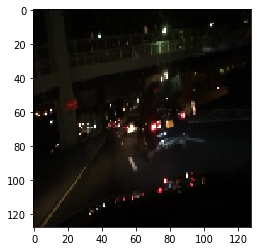

In [23]:
plt.imshow(image_batch[0])